# Getting started

If you don't have a python environment already ready, you will need to make one.

Linux or Mac is recommended, but Windows is possible, albiet with more difficulty.

There are multiple ways to do it, but miniconda is recommended:
https://docs.conda.io/en/latest/miniconda.html



Linux/Mac:

1) Download latest

2) install in Bash terminal 

3) create+activate new environment 

4) pip install notebook scanpy scvi seaborn 

5) launch notebook with: jupyter notebook 

In [1]:
import scanpy as sc #single cell analysis package
import pandas as pd #dataframe package
import scvi #we will use for doublet removal
import numpy as np #stats/data handling
from scipy import stats #stats
import seaborn as sns #plotting package

import matplotlib.pyplot as plt #plotting modification
from matplotlib.pyplot import rc_context #make plots look pretty

#you can install package directly in a jupyter cell, e.g.: %pip install scanpy

ModuleNotFoundError: No module named 'scanpy'

# Initial depletion test

### Here we will do a quick comparison between the depleted and control samples

There are two ways to load in 10x data -- both are default cellranger output:

1) the .h5 file which I use below. You will need to run .var_names_make_unique() after loading

2) pointing to the filtered_feature_bc_matrix directory. There is an example below that has been commented out.

In either case you want the filtered data, not the raw data.

In [2]:
#load in data from .h5
#example data are PBMCs

control = sc.read_10x_h5('control_filtered_no_mask.h5')
control.var_names_make_unique()


depleted = sc.read_10x_h5('depleted_filtered_no_mask_rep3.h5')
depleted.var_names_make_unique()

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
'''
if your 10x output is the bc matrix directory instead...

the complete path should be a directory with:
barcodes.tsv.gz, features.tsv.gz, and matrix.mtx.gz inside it

if you have these three files not contained in a directory, put them in one

'''

#adata = sc.read_10x_mtx('path_to_sample_output_dir/outs/filtered_feature_bc_matrix/')

'\nif your 10x output is the bc matrix directory instead...\n\nthe complete path should be a directory with:\nbarcodes.tsv.gz, features.tsv.gz, and matrix.mtx.gz inside it\n\nif you have these three files not contained in a directory, put them in one\n\n'

In [10]:
#Loading in the list of depleted targets. It's a text file where each line is a gene.
with open('targets_2.txt') as f:
    targets = [x.strip() for x in list(f) if x.strip() in control.var_names]

In [5]:
len(targets)

350

#### Below we create a dataframe where each row is an individual cell.  Each value is the % of reads belonging to the depleted target genes. When the dataframe is plotted a box plot, we see a very significant reduction resulting from depletion.|

In [8]:
#

a = control.X.sum(axis = 1) #sum of all cells/genes
b = control[:,targets].X.sum(axis = 1) #sum of all cells/targets
c = b/a *100 #percent of counts that belong to targets

df = pd.DataFrame(c, columns = ['% of total counts'])
df['Sample'] = 'control'

df.head() #only top 5 rows shown

,% of total counts,Sample
0,68.690658,control
1,48.316500,control
2,64.772099,control
3,60.834002,control
4,46.849564,control


In [9]:
a = depleted.X.sum(axis = 1) #sum of all cells/genes
b = depleted[:,targets].X.sum(axis = 1) #sum of all cells/targets
c = b/a * 100#percent of counts that belong to targets

df2 = pd.DataFrame(c, columns = ['% of total counts'])
df2['Sample'] = 'depleted'

df2.head()

,% of total counts,Sample
0,8.900364,depleted
1,6.849894,depleted
2,10.913706,depleted
3,9.225572,depleted
4,8.272351,depleted


In [10]:
df = pd.concat((df, df2)) #combine both into one for plotting
df

,% of total counts,Sample
0,68.690658,control
1,48.316500,control
2,64.772099,control
3,60.834002,control
4,46.849564,control
...,...,...
11781,7.590759,depleted
11782,7.002731,depleted
11783,10.717941,depleted
11784,11.223751,depleted


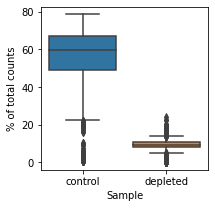

In [11]:
plt.figure(figsize = (3,3))

ax = sns.boxplot(data = df, x = 'Sample', y = '% of total counts') #plot above dataframe

In [12]:
#mann whitney U test
stats.mannwhitneyu(df[df.Sample == 'depleted']['% of total counts'].values,
                  df[df.Sample == 'control']['% of total counts'].values)

MannwhitneyuResult(statistic=2768257.5, pvalue=0.0)

#### Next, we can plot the difference in genes per UMI (total counts) on an individual cell level. We observe a large increase in the average number of genes per cell in the depeleted sample.

In [13]:
control.obs['Sample'] = 'control' #adding label keys
depleted.obs['Sample'] = 'depleted'


combined = sc.concat((control, depleted), index_unique = '_') #combining into one object to plot easier
sc.pp.filter_cells(combined, min_genes=400) #simple QC to remove junk cells

In [14]:
#calculate the number of genes and total counts
sc.pp.calculate_qc_metrics(combined, percent_top=None, log1p=False, inplace=True)

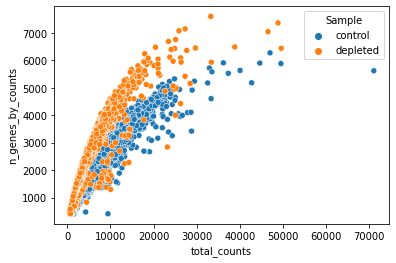

In [15]:
#number of genes by count
ax = sns.scatterplot(data = combined.obs,
                     x = 'total_counts', y = 'n_genes_by_counts', hue = 'Sample')

In [16]:
#Here we bin the above data to plot on a line

out = []
for x in range(600,12000, 100):
    
    a = combined.obs[(combined.obs.Sample == 'control')\
                & ((combined.obs.total_counts >= x -50) &\
                   (combined.obs.total_counts < x + 50))].n_genes_by_counts.values #conroled bined values
    
    
    
    b = combined.obs[(combined.obs.Sample == 'depleted')\
                & ((combined.obs.total_counts >= x -50) &\
                   (combined.obs.total_counts < x + 50))].n_genes_by_counts.values #depleted bined values
    
    c = stats.mannwhitneyu(a, b).pvalue
    
    #append stats to list
    out.append(['control', x, a.mean(),c])
    
    out.append(['depleted', x, b.mean(), c])
    
    
df = pd.DataFrame(out, columns = ['Sample', 'total_counts', 'n_genes', 'pvalue']) #turn list into dataframe

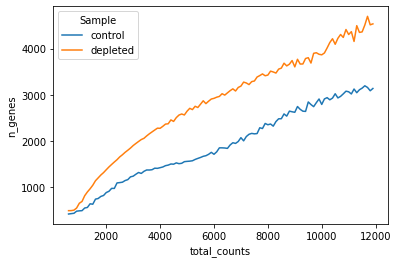

In [17]:
#number of genes by binned count
ax = sns.lineplot(data = df, x = 'total_counts', y = 'n_genes', hue = 'Sample')

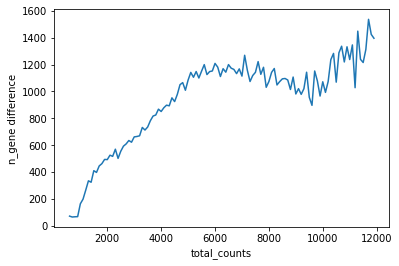

In [18]:
#Difference between the depleted and control at every bin.
#We observe >1000 more genes/cell above 4000 counts

ax = sns.lineplot(x = range(600,12000, 100),
             y = df[df.Sample == 'depleted'].n_genes.values - df[df.Sample == 'control'].n_genes.values)

plt.xlabel('total_counts')
plt.ylabel('n_gene difference')


plt.show()

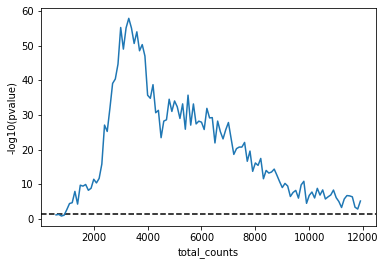

In [19]:
#highly significant difference between control and depleted past 1000 counts
#Note: dropoff and noise at higher total_counts due to reduced sample size
ax = sns.lineplot(x = range(600,12000, 100),
             y = -np.log10(df[df.Sample == 'depleted'].pvalue))

plt.ylabel('-log10(pvalue)')
plt.xlabel('total_counts')

plt.axhline(-np.log10(0.05), zorder = 0, c = 'k', ls = '--') #line of significance

plt.show()

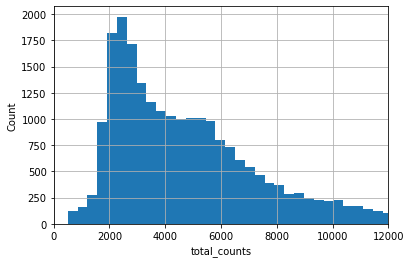

In [20]:
#distrubtion of total_counts in both samples
#Distribution shows majority of cells have very significant differences in n_genes (compared to above plot)
ax = pd.concat((combined.obs, control.obs)).total_counts.hist(bins = 200)

plt.xlim(right = 12000, left = 0)

plt.xlabel('total_counts')
plt.ylabel('Count')

plt.show()

### Comparison of "important" genes: UMI/cell and Genes/cell benefit

#### Since the >300 depleted genes poorly describe cell heterogenity, we can compare only the descriptive genes between the two samples. Below we remove the depleted targets, then compare individual cell statistics.

In [31]:
#remove depleted genes from both objects

combined = combined[:,[x for x in combined.var_names if x not in targets]]



In [33]:
#recalculate qc metrics because we removed genes
sc.pp.calculate_qc_metrics(combined, percent_top=None, log1p=False, inplace=True)

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


#### The number of descriptive genes and UMI counts are higher in the depleted sample

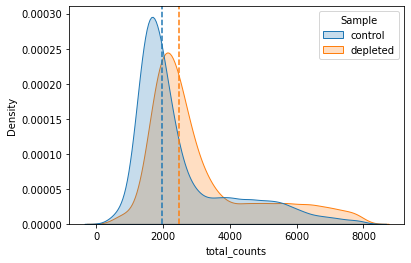

In [60]:
#number of total UMI/cell

temp = combined.obs[combined.obs.total_counts < 8000]

ax = sns.kdeplot(data = temp,
                 x = 'total_counts', hue = 'Sample', fill=True)

ax.axvline(temp[temp.Sample == 'control'].total_counts.median(), ls = '--', c = 'tab:blue')
ax.axvline(temp[temp.Sample == 'depleted'].total_counts.median(), ls = '--', c = 'tab:orange')

plt.show()

In [61]:
stats.mannwhitneyu(temp[temp.Sample == 'control'].total_counts, 
                  temp[temp.Sample == 'depleted'].total_counts)

MannwhitneyuResult(statistic=42269762.0, pvalue=1.0704477249708275e-304)

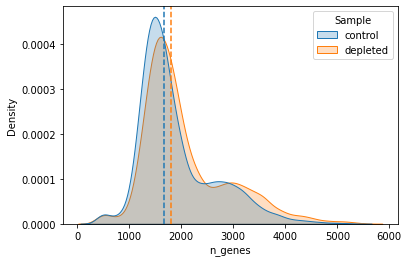

In [70]:
#number of genes/cell
temp = combined.obs[combined.obs.n_genes < 5500]

ax = sns.kdeplot(data = temp,
                 x = 'n_genes', hue = 'Sample', fill=True)

ax.axvline(temp[temp.Sample == 'control'].n_genes.median(), ls = '--', c = 'tab:blue')
ax.axvline(temp[temp.Sample == 'depleted'].n_genes.median(), ls = '--', c = 'tab:orange')

plt.show()

In [63]:
stats.mannwhitneyu(temp[temp.Sample == 'control'].total_counts, 
                  temp[temp.Sample == 'depleted'].total_counts)

MannwhitneyuResult(statistic=44098022.0, pvalue=0.0)

# Clustering/heterogeneity

### Next we will process the data to look at differences in heterogeneity and clustering

#### Preprocessing: We need to remove doublets, dead cells, and outliers

In [3]:
#reload the data

control = sc.read_10x_h5('control_filtered_no_mask.h5')
control.var_names_make_unique()


depleted = sc.read_10x_h5('depleted_filtered_no_mask_rep3.h5')
depleted.var_names_make_unique()

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [23]:
control #num cells x num genes

AnnData object with n_obs × n_vars = 11714 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [24]:
depleted

AnnData object with n_obs × n_vars = 11786 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [25]:
'''
Doublet removal is important/recommended, but not 100% necessary. This step will add several minutes
for every sample IF you have a gpu. If you do not have a GPU, it will add even more time.

If you opt out of doublet removal, you will need to be more liberal when removing cells with
high n_genes_by_counts later on in QC.
For exmaple, to remove the top 5% (to be run after calculate_qc_metrics later on):
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .95)
adata = adata[adata.obs.n_genes_by_counts < upper_lim]

'''

#pass adata, return adata with doublets removed
def remove_doublets(adata, threshold = 0):
    cdata = adata.copy()
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train(max_epochs = 200) #increase max_epochs to 400 if you are willing to wait longer
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train(max_epochs = 200)
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > threshold)]
    
    
    
    cdata.obs['doublet'] = cdata.obs.index.isin(doublets.index)
    cdata = cdata[~cdata.obs.doublet]
    
    
    return cdata
    
    
    

In [26]:
#A threshold of 0 is recommended. But you can increase threshold to reduce number of doublets removed

control = remove_doublets(control, threshold = 0)
depleted = remove_doublets(depleted, threshold = 0)

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 200/200: 100%|███████| 200/200 [04:48<00:00,  1.44s/it, loss=628, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 188/200:  94%|████▋| 188/200 [01:23<00:05,  2.25it/s, loss=0.209, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.195. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 200/200: 100%|███████| 200/200 [04:47<00:00,  1.44s/it, loss=620, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 200/200: 100%|█████| 200/200 [01:30<00:00,  2.21it/s, loss=0.216, v_num=1]


In [27]:
control #a little over 1k doublets were removed, this will vary by project/sample
#it will also vary slightly due to randomness inherent in the learning-based doublet removal 

View of AnnData object with n_obs × n_vars = 10438 × 36601
    obs: 'doublet'
    var: 'gene_ids', 'feature_types', 'genome'

In [28]:
depleted

View of AnnData object with n_obs × n_vars = 10276 × 36601
    obs: 'doublet'
    var: 'gene_ids', 'feature_types', 'genome'

In [15]:
#broadinstitute has a list of annotated ribosomal genes
#here we grab it from their website and turn it into a dataframe

url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(url, skiprows=2, header = None)
ribo_genes.head() #only top 5 rows shwon below

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L


In [31]:
'''
So far we have only removed doublets. Time to do some QC.
'''

def qc(adata):
    
    #get rid of cells with fewer than 400 genes
    sc.pp.filter_cells(adata, min_genes=400) #you can lower this depending on your dataset
    
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    
    # annotate the group of mitochondrial genes as 'mt' in adata.var
    #'MT-' is case sensitive! double check your adata.obs after to make sure you have values for mt
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  
    
    
    # annotate the group of ribo genes as 'ribo' in adata.var
    #If you have mouse data you will need to make sure the capitalization matches
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    
    
    #uncomment out the two lines below if you dont do doublet removal
    #upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .95)
    #adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    
    return adata

In [32]:
control = qc(control)
depleted = qc(depleted)

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [33]:
control

AnnData object with n_obs × n_vars = 9973 × 20776
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [34]:
depleted

AnnData object with n_obs × n_vars = 9884 × 20707
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

#### Typically, people remove cells with a MT% above a certain threshold, like 10, 15, or 20%

#### But, with the depleted sample, the MT% is greatly reduced. Instead of picking a standard threshold we will remove cells three standard deviations above the mean

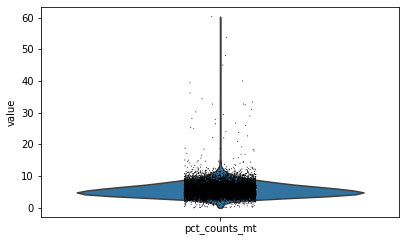

In [35]:
#The control looks like a typical single-cell sample
#We can pick a percent, but we will also apply the above mentioned method for consistency
sc.pl.violin(control, 'pct_counts_mt')

In [36]:
#set a cutoff that is 3 std + mean
cutoff = control.obs.pct_counts_mt.mean() + 3*control.obs.pct_counts_mt.std()
cutoff

13.394201755523682

In [ ]:
#use cutoff to filter out all cells above it
control = control[control.obs.pct_counts_mt < cutoff]

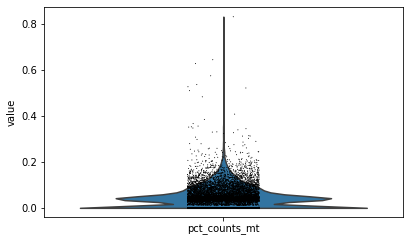

In [37]:
#notice big reduction in MT counts, and much lower cutoff
sc.pl.violin(depleted, 'pct_counts_mt')

In [38]:
cutoff = depleted.obs.pct_counts_mt.mean() + 3*depleted.obs.pct_counts_mt.std()
cutoff

0.1973622478544712

In [39]:
depleted = depleted[depleted.obs.pct_counts_mt < cutoff]

#### Proportion of ribosomal reads is greatly reduced. We won't use these to filter for now, but we will regress it out later

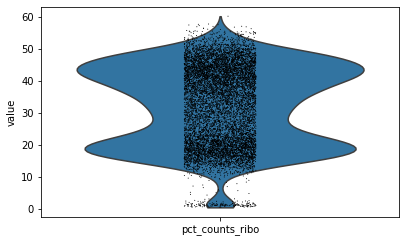

In [42]:
sc.pl.violin(control, 'pct_counts_ribo')

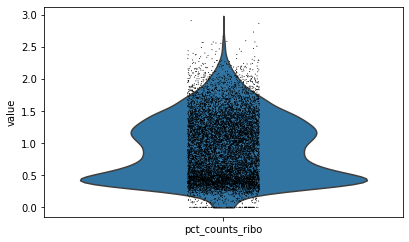

In [43]:
sc.pl.violin(depleted, 'pct_counts_ribo')

In [ ]:
#QC is done, the below objets represent the final filtered data

In [40]:
control #final num cells x genes

AnnData object with n_obs × n_vars = 9973 × 20776
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [41]:
depleted #final num cells x genes

View of AnnData object with n_obs × n_vars = 9772 × 20707
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Normalization, scaling, UMAP, clustering

In [44]:
def process(adata):
    sc.pp.normalize_total(adata, target_sum = 1e4) #each gene scaled to 10,000 counts
    sc.pp.log1p(adata) #log scale
    adata.raw = adata #raw data saved as raw, this is used in many downstream functions
    
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000) #find variable features
    adata = adata[:, adata.var.highly_variable] #subset data on variable features (doesn't affect raw)
    
    #regress out the effects of counts, mito reads, and ribo reads
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

    sc.pp.scale(adata, max_value=10) #scale each gene to unit variance
    

    sc.tl.pca(adata, svd_solver='arpack') #calculate PCAs for dim reduction

    sc.pp.neighbors(adata, n_pcs = 30) #find neighbors
    
    sc.tl.umap(adata) #calculate UMAP coordinates
    
    sc.tl.leiden(adata, resolution = 0.5) #cluster with leiden (similar to louavain)
    
    return adata

In [45]:
control = process(control)
depleted = process(depleted)

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


#### Both samples were processed the same and clustered with the same resolution. However, we see additional cell populations and more separation in the depleted sample

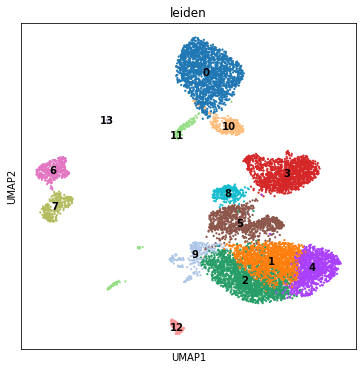

In [95]:
with rc_context({'figure.figsize': (6,6)}): #size of plot
    sc.pl.umap(control, color = 'leiden', s = 20, legend_loc = 'on data')

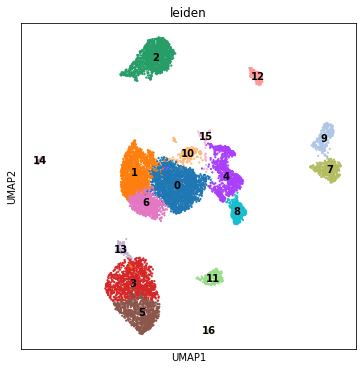

In [96]:
with rc_context({'figure.figsize': (6,6)}): #size of plot
    sc.pl.umap(depleted, color = 'leiden', s = 20, legend_loc = 'on data')

#### Rough annotation of clusters

In [91]:
control_cells =  {
    '0':'CD14+ Monocyte',
    '1':'CD4+ T cell',
    '2':'CD4+ T cell',
    '3':'NK cell',
    '4':'CD4+ T cell',
    '5':'CD8+ T cell',
    '6':'B cell',
    '7':'B cell',
    '8':'NKT cell',
    '9':'CD4+ T cell',
    '10':'CD16+ Monocyte',
    '11':'DC',
    '12':'Platelet',
    '13': 'uknown'    
}

control.obs['cell_type'] = control.obs.leiden.map(control_cells)

In [92]:
depleted_cells = {
 '0': 'CD4+ T cell',
 '1': 'CD4+ T cell',
 '2': 'NK cell',
 '3': 'CD14+ Monocyte',
 '4': 'CD8+ T cell',
 '5': 'CD14+ Monocyte',
 '6': 'CD4+ T cell',
 '7': 'B cell',
 '8': 'NKT cell',
 '9': 'B cell',
 '10': 'CD4+ T cell',
 '11': 'CD16+ Monocyte',
 '12': 'Platelet',
 '13': 'DC',
 '14': 'PDC',
 '15': 'MKI67+',
 '16': 'CDK4+CD34+',
}

depleted.obs['cell_type'] = depleted.obs.leiden.map(depleted_cells)

In [99]:
#write to file, load with sc.read_h5ad()
control.write_h5ad('control.h5ad')
depleted.write_h5ad('depleted.h5ad')

#### Below we see several differences between control and depleted.

#### For example: 1) CD14+ monocytes are split into two clusters in depleted.

#### 2) PDCs were not clustered separately from DCs (even though distant in UMAP) in the control. But were in the depleted

#### 3) Depletion revealed a MKI67+ and CDK4/CD34+ progenitor populations

#### 4) CD16+ monocytes are more transcriptionally distinct in the depleted cells

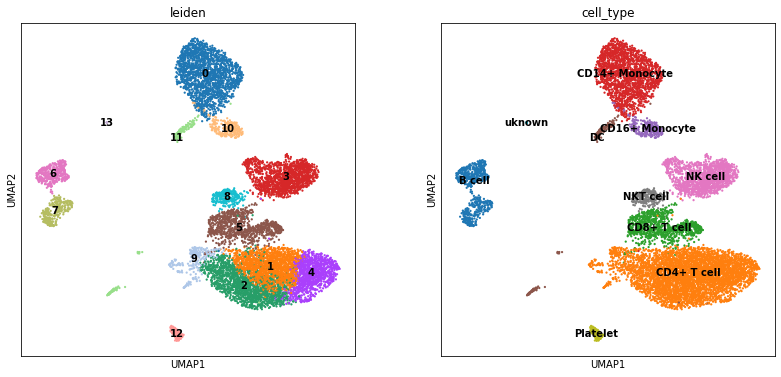

In [97]:
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.umap(control, color = ['leiden', 'cell_type'], s = 20, legend_loc = 'on data')

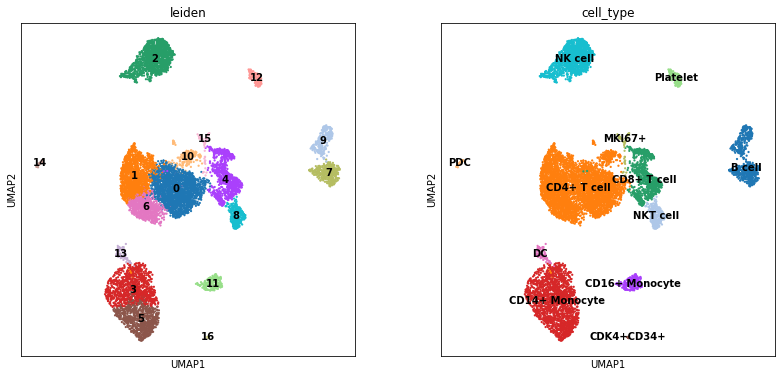

In [98]:
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.umap(depleted, color = ['leiden', 'cell_type'], s = 20, legend_loc = 'on data')

# Additional figure/comparison examples + aesthetic

In [4]:
control = sc.read_h5ad('control.h5ad')
depleted = sc.read_h5ad('depleted.h5ad')

In [5]:
control_cells =  {
    '0':'CD14+ Mon',
    '1':'CD4+ T',
    '2':'CD4+ T ',
    '3':'NK cell',
    '4':'CD4+ T  ',
    '5':'CD8+ T',
    '6':'B cell',
    '7':'B cell ',
    '8':'NKT',
    '9':'Treg',
    '10':'CD16+ Mon',
    '11':'DC',
    '12':'Platelet',
    '13': 'uknown'    
}

control.obs['cell_type'] = control.obs.leiden.map(control_cells)

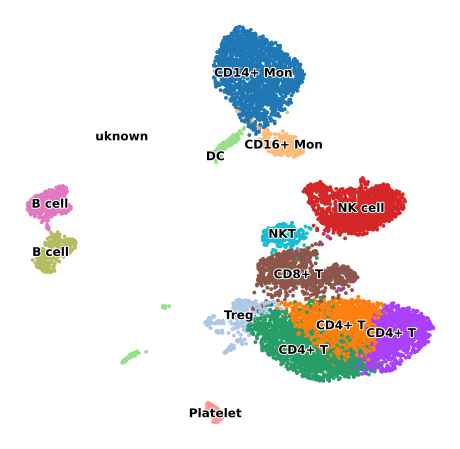

In [6]:
with rc_context({'figure.figsize': (8,8)}):
    sc.pl.umap(control, color = ['cell_type'], s = 60, legend_loc = 'on data', frameon=False,
               legend_fontsize=12, legend_fontoutline=2, title='', save = 'control')

In [7]:
depleted_cells = {
 '0': 'CD4+ T',
 '1': 'CD4+ T ',
 '2': 'NK cell',
 '3': 'CD14+ Mon ',
 '4': 'CD8+ T',
 '5': 'CD14+ Mon',
 '6': 'CD4+ T  ',
 '7': 'B cell',
 '8': 'NKT cell',
 '9': 'B cell ',
 '10': 'Treg',
 '11': 'CD16+ Mon',
 '12': 'Platelet',
 '13': 'DC',
 '14': 'PDC',
 '15': 'MKI67+',
 '16': 'CDK4+CD34+',
}

depleted.obs['cell_type'] = depleted.obs.leiden.map(depleted_cells)

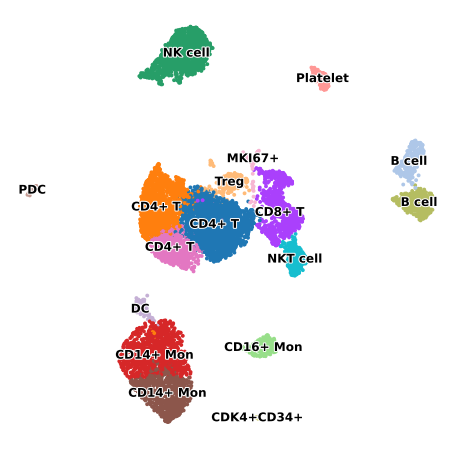

In [8]:
with rc_context({'figure.figsize': (8,8)}):
    sc.pl.umap(depleted, color = ['cell_type'], s = 60, legend_loc = 'on data', frameon=False,
               legend_fontsize=12, legend_fontoutline=2, title='', save = 'depleted')

In [9]:
#reload fresh to make pretty comparison figures

control = sc.read_10x_h5('control_filtered_no_mask.h5')
control.var_names_make_unique()


depleted = sc.read_10x_h5('depleted_filtered_no_mask_rep3.h5')
depleted.var_names_make_unique()

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
a = control.X.sum(axis = 1) #sum of all cells/genes
b = control[:,targets].X.sum(axis = 1) #sum of all cells/targets
c = b/a *100 #percent of counts that belong to targets

df = pd.DataFrame(c, columns = ['% of total counts'])
df['Sample'] = 'control'

a = depleted.X.sum(axis = 1) #sum of all cells/genes
b = depleted[:,targets].X.sum(axis = 1) #sum of all cells/targets
c = b/a * 100#percent of counts that belong to targets

df2 = pd.DataFrame(c, columns = ['% of total counts'])
df2['Sample'] = 'depleted'

df = pd.concat((df, df2)) #combine both into one for plotting
df

,% of total counts,Sample
0,68.690658,control
1,48.316500,control
2,64.772099,control
3,60.834002,control
4,46.849564,control
...,...,...
11781,7.590759,depleted
11782,7.002731,depleted
11783,10.717941,depleted
11784,11.223751,depleted


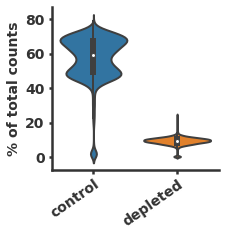

In [12]:
plt.figure(figsize = (3,3))

ax = sns.violinplot(data = df, x = 'Sample', y = '% of total counts', scale='width', linewidth=2)


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 14, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 14, weight = 'bold', color = '0.2')

ax.tick_params(width = 2.5, color = '0.2')


plt.ylabel('% of total counts',size = 14, weight = 'bold', color = '0.2')
plt.xlabel('')


#plt.savefig('figures/depletion_vio.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [13]:
control.obs['Sample'] = 'control' #adding label keys
depleted.obs['Sample'] = 'depleted'


combined = sc.concat((control, depleted), index_unique = '_') #combining into one object to plot easier
sc.pp.filter_cells(combined, min_genes=400) #simple QC to remove junk cells


In [16]:
combined.var['mt'] = combined.var_names.str.startswith('MT-')
combined.var['ribo'] = combined.var_names.isin(ribo_genes[0].values)
sc.pp.calculate_qc_metrics(combined, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)


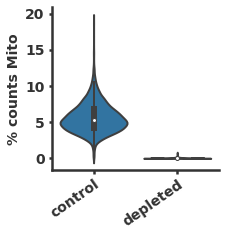

In [17]:
plt.figure(figsize = (3,3))


ax = sns.violinplot(data = combined.obs[combined.obs.pct_counts_mt < 20],
                    x = 'Sample', y = 'pct_counts_mt', scale='width', linewidth=2)


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 14, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 14, weight = 'bold', color = '0.2')

ax.tick_params(width = 2.5, color = '0.2')


plt.ylabel('% counts Mito',size = 14, weight = 'bold', color = '0.2')
plt.xlabel('')


#plt.savefig('figures/mito_viol.png', dpi = 300, bbox_inches = 'tight')

plt.show()


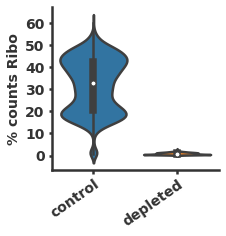

In [18]:
plt.figure(figsize = (3,3))

ax = sns.violinplot(data = combined.obs,
                    x = 'Sample', y = 'pct_counts_ribo', scale='width', linewidth=2.5)


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 14, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 14, weight = 'bold', color = '0.2')

ax.tick_params(width = 2.5, color = '0.2')


plt.ylabel('% counts Ribo',size = 14, weight = 'bold', color = '0.2')
plt.xlabel('')


#plt.savefig('figures/ribo_vio.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [19]:
combined = combined[:,[x for x in combined.var_names if x not in targets]]

sc.pp.calculate_qc_metrics(combined, percent_top=None, log1p=False, inplace=True)

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


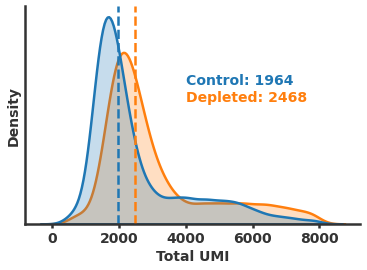

In [20]:
#number of total UMI/cell

temp = combined.obs[combined.obs.total_counts < 8000]

ax = sns.kdeplot(data = temp,
                 x = 'total_counts', hue = 'Sample', fill=True, linewidth=2.5)


ax.axvline(temp[temp.Sample == 'control'].total_counts.median(), ls = '--', c = 'tab:blue', lw = 2.5)
ax.axvline(temp[temp.Sample == 'depleted'].total_counts.median(), ls = '--', c = 'tab:orange', lw = 2.5)


#plt.legend(frameon = False, prop = {'weight':'bold', 'size':14}, labelcolor = '0.2')



for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 14, weight = 'bold', color = '0.2')
plt.yticks([])

ax.tick_params(width = 2.5, color = '0.2')



plt.ylabel('Density', size = 14, weight = 'bold', color = '0.2')
plt.xlabel('Total UMI', size = 14, weight = 'bold', color = '0.2')


ax.legend([],[], frameon=False)



plt.text(s = f"Control: {round(temp[temp.Sample == 'control'].total_counts.median())}",
           x = 4000, y = .0002, c = 'tab:blue', size = 14, weight = 'bold')

plt.text(s = f"Depleted: {round(temp[temp.Sample == 'depleted'].total_counts.median())}",
           x = 4000, y = .000175, c = 'tab:orange', size = 14, weight = 'bold')





#plt.savefig('figures/umi_dist.png', dpi = 300, bbox_inches = 'tight')



plt.show()

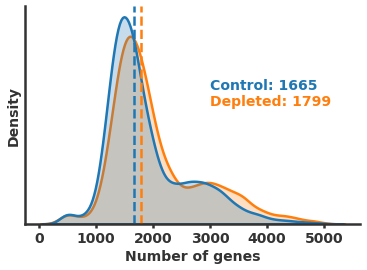

In [21]:
#number of total UMI/cell

temp = combined.obs[combined.obs.n_genes < 5000]

ax = sns.kdeplot(data = temp,
                 x = 'n_genes', hue = 'Sample', fill=True, linewidth=2.5)


ax.axvline(temp[temp.Sample == 'control'].n_genes.median(), ls = '--', c = 'tab:blue', lw = 2.5)
ax.axvline(temp[temp.Sample == 'depleted'].n_genes.median(), ls = '--', c = 'tab:orange', lw = 2.5)


#plt.legend(frameon = False, prop = {'weight':'bold', 'size':14}, labelcolor = '0.2')



for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 14, weight = 'bold', color = '0.2')
plt.yticks([])

ax.tick_params(width = 2.5, color = '0.2')



plt.ylabel('Density', size = 14, weight = 'bold', color = '0.2')
plt.xlabel('Number of genes', size = 14, weight = 'bold', color = '0.2')


ax.legend([],[], frameon=False)



plt.text(s = f"Control: {round(temp[temp.Sample == 'control'].n_genes.median())}",
           x = 3000, y = .0003, c = 'tab:blue', size = 14, weight = 'bold')

plt.text(s = f"Depleted: {round(temp[temp.Sample == 'depleted'].n_genes.median())}",
           x = 3000, y = .000265, c = 'tab:orange', size = 14, weight = 'bold')



#plt.savefig('figures/gene_dist.png', dpi = 300, bbox_inches = 'tight')



plt.show()